In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
SRC_PATH = '/content/gdrive/MyDrive/MP FEB/Colab'
sys.path.append(SRC_PATH)

!pip install wandb -qqq
import wandb
wandb.login()

wandb.init(
    # Set the project where this run will be logged
    project="DDHT_poc", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    #name="experiment 1"
    # Track hyperparameters and run metadata
    #config={
      #"learning_rate": 0.02,
      #"architecture": "CNN",
      #"dataset": "CIFAR-100",
      #"epochs": 10,}
    )

In [2]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [3]:
from torch.utils.data import DataLoader
from poc_data import PocDataset, display_sample


NUM_CASES = 2**6
BATCH_SIZE = 2**4

poc_raw_dataset = PocDataset(num_cases=NUM_CASES, augment=True)
data_loader = DataLoader(dataset=poc_raw_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        pin_memory=True)

batch_data, batch_data_length, batch_event, batch_tte, _ = next(iter(data_loader))

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)

torch.Size([16, 24, 5])
torch.Size([16, 1])
torch.Size([16, 1])


### Data Exploration

Length is 11, Event is 0
Length is 9, Event is 1
Length is 18, Event is 3
Length is 23, Event is 3


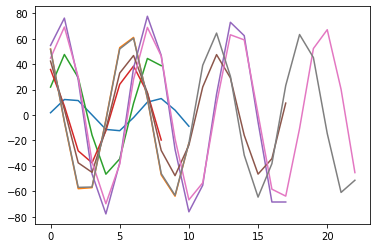

In [4]:
#Take a look at the longitudional data
display_sample(batch_data[0], batch_data_length[0], batch_event[0])
display_sample(batch_data[1], batch_data_length[1], batch_event[1])
display_sample(batch_data[2], batch_data_length[2], batch_event[2])
display_sample(batch_data[3], batch_data_length[3], batch_event[3])

### Test Sample

Length is 6, Event is 0


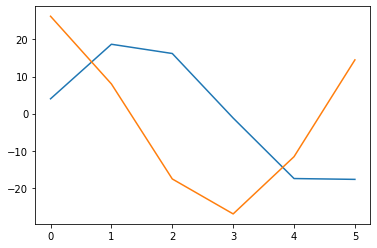

In [5]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,pin_memory=True)
test_batch_data, test_batch_data_length, test_batch_event, test_tte, test_meta = next(iter(test_data_loader))
display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])

# 2. Hyperparameters

In [6]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 1

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = BATCH_SIZE

input_size = 5
output_size = input_size
MAX_LENGTH = 2*12
NUM_CAUSES = 3
hidden_size_encoder = 256
hidden_size_attention = 512
fc_size_encoder = 512
SIGMA = 0.1

# 3. Defining The Model

In [7]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attention, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)

# 4. Training the model

In [ ]:
PATH = "/content/gdrive/MyDrive/MP FEB/Colab/models/model_v15.pth"

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event, batch_tte, _ = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    batch_tte = batch_tte.to(DEVICE)
    
    output_batch, first_hitting_time_batch = DDHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, MAX_LENGTH, DEVICE)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    wandb.log({"train_loss1": loss1.item(), "train_loss2": loss2.item(), "train_loss3": loss3.item()})

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

    if batch_number % 2**8 == 0:
      torch.save(DDHT.state_dict(), PATH)


  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_batch_data, val_data_length, val_batch_event, val_batch_tte, _ = next(iter(val_data_loader))
      val_batch_data = val_batch_data.to(DEVICE)
      val_data_length = val_data_length.to(DEVICE)
      val_batch_event = val_batch_event.to(DEVICE)
      val_batch_tte = val_batch_tte.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_batch_data, val_data_length)

      val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, MAX_LENGTH, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

      wandb.log({"val_loss1": val_loss1.item(), "val_loss2": val_loss2.item(), "val_loss3": val_loss3.item()})
      wandb.log({"train_epoch_loss" : epoch_loss.item(), "val_epoch_loss" : val_loss1.item() + val_loss2.item() + val_loss3.item(),"epoch": epoch})

    DDHT.train()
    # end validating round

  torch.save(DDHT.state_dict(), PATH)

wandb.finish() 

# 4. Testing the Model

### Predicting the test sample

In [167]:
# PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_v14_2048.pth"
# #torch.save(DDHT.state_dict(), PATH)
# DDHT.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Scoring our model - sampling a new test set

sample has length 14
sample will experience event 1 at time 15, but shows event 3
the model predicts the event 1 at time 15
probability of prepay event = 0.01
probability of default event = 0.99
probability of full repay event = 0.00


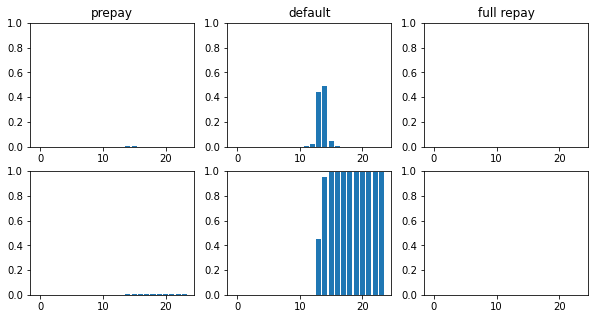

In [172]:
from utils import plot_fht_and_cif
from losses import CIF_K_tau

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = poc_raw_dataset = PocDataset(num_cases=1, test_set=True, repays=False)
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte, test_meta = next(iter(test_data_loader))
test_batch_data = test_batch_data.unsqueeze(0).to(DEVICE)
test_batch_data_length = test_batch_data_length.unsqueeze(0).to(DEVICE)
test_batch_event = test_batch_event.unsqueeze(0).to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time = DDHT(test_batch_data, test_batch_data_length)
print("sample has length %d" % test_batch_data_length[0])
print("sample will experience event %d at time %d, but shows event %d" % (test_meta['ground_truth_event'], test_meta['age'], test_batch_event[0]))


test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts the event %d at time %d" % (model_event_prediction, model_tte_prediction + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 0, 24, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 1, 24, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 2, 24, test_batch_data_length[0], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[0], test_batch_data_length[0], MAX_LENGTH)

In [171]:
#Probability that this loan will prepay, default or repay in the comming "delta" months?
delta = 6
evaluation_time = min(int(test_batch_data_length[0].item()) + delta, MAX_LENGTH)
print("In the comming %d months, the probability that a specific event happens is:" % delta)

p_ev0 = CIF_K_tau(test_first_hitting_time[0], 0, evaluation_time, test_batch_data_length[0], MAX_LENGTH).item()
p_ev1 = CIF_K_tau(test_first_hitting_time[0], 1, evaluation_time, test_batch_data_length[0], MAX_LENGTH).item()
p_ev2 = CIF_K_tau(test_first_hitting_time[0], 2, evaluation_time, test_batch_data_length[0], MAX_LENGTH).item()

print("probability a prepay happens = %.3f" % p_ev0)
print("probability a default happens = %.3f" % p_ev1)
print("probability a full repay happens = %.3f" % p_ev2)

sum = p_ev0 + p_ev1 + p_ev2
print("The probability anything happens = %.3f" % sum)


In the comming 6 months, the probability that a specific event happens is:
probability a prepay happens = 0.984
probability a default happens = 0.000
probability a full repay happens = 0.000
The probability anything happens = 0.984
